# Time-series Forecasting

## Description
The data consists of 52,416 observations of energy consumption on a 10-minute window. Every observation is described by the following feature columns.

Your task is to aggregate the observations on an interval of 30 minutes. For this time interval, using the values of the 5 previous time intervals, forecast the target value one step in the future. Choose which features you are going to use.

**You must train a Boosting model for the task. Choose the model based on the number, and type of features available.**



Features:

* Date: Time window of ten minutes.
* Temperature: Weather Temperature.
* Humidity: Weather Humidity.
* WindSpeed: Wind Speed.
* GeneralDiffuseFlows: “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
* DiffuseFlows

Target:

SolarPower

## Dataset links:
* [DS1](https://drive.google.com/file/d/1-Pcpb1xWpKc8Cgs-P7xqBFHw2NM0dBsA/view?usp=sharing)
* [DS2](https://drive.google.com/file/d/1-Pul07w6LXpm-uo99qbNc86FHhwl4yQD/view?usp=sharing)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
from sklearn import metrics
from xgboost import XGBClassifier, XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Read the datasets

In [466]:
df1 = pd.read_csv('power_consumption_g3_feat.csv')
df2 = pd.read_csv('power_consumption_g3.csv')
df1.sample(3)

,Date,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
12551,2017-09-23 21:10:00,21.63,84.00,4.923,0.077,0.126
155,2017-01-29 09:10:00,13.59,60.73,4.922,124.800,108.700
3870,2017-01-24 16:20:00,16.38,27.55,0.086,315.800,378.500


In [468]:
df2.sample(3)

,Date,SolarPower
31890,2017-02-16 06:10:00,24071.18644
12928,2017-03-22 00:10:00,29032.85106
43813,2017-09-29 05:20:00,27806.01770


## Merge the datasets (and pre-processing if needed)

In [313]:
merged_df = pd.merge(df1,df2,on='Date')
merged_df['WindSpeed'].describe()

count    51887.000000
mean         1.960152
std          2.349013
min          0.050000
25%          0.078000
50%          0.086000
75%          4.915000
max          6.483000
Name: WindSpeed, dtype: float64

In [315]:
copy_df = merged_df.copy() 

In [317]:
copy_df[['WindSpeed', 'SolarPower']].corr()

,WindSpeed,SolarPower
WindSpeed,1.000000,0.167222
SolarPower,0.167222,1.000000


In [319]:
#nema visoka korelacija so target promenlivata, moze i da se dropne

In [321]:
copy_df.isnull().sum() 

Date                     0
Temperature            559
Humidity               499
WindSpeed              529
GeneralDiffuseFlows    524
DiffuseFlows           505
SolarPower               0
dtype: int64

In [323]:
len(copy_df['SolarPower'].unique())

27709

array([[<Axes: title={'center': 'Temperature'}>,
        <Axes: title={'center': 'Humidity'}>],
       [<Axes: title={'center': 'WindSpeed'}>,
        <Axes: title={'center': 'GeneralDiffuseFlows'}>],
       [<Axes: title={'center': 'DiffuseFlows'}>,
        <Axes: title={'center': 'SolarPower'}>]], dtype=object)

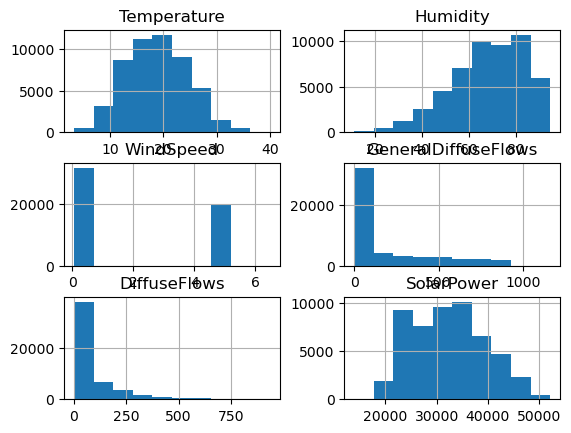

In [327]:
copy_df.hist()

<Axes: >

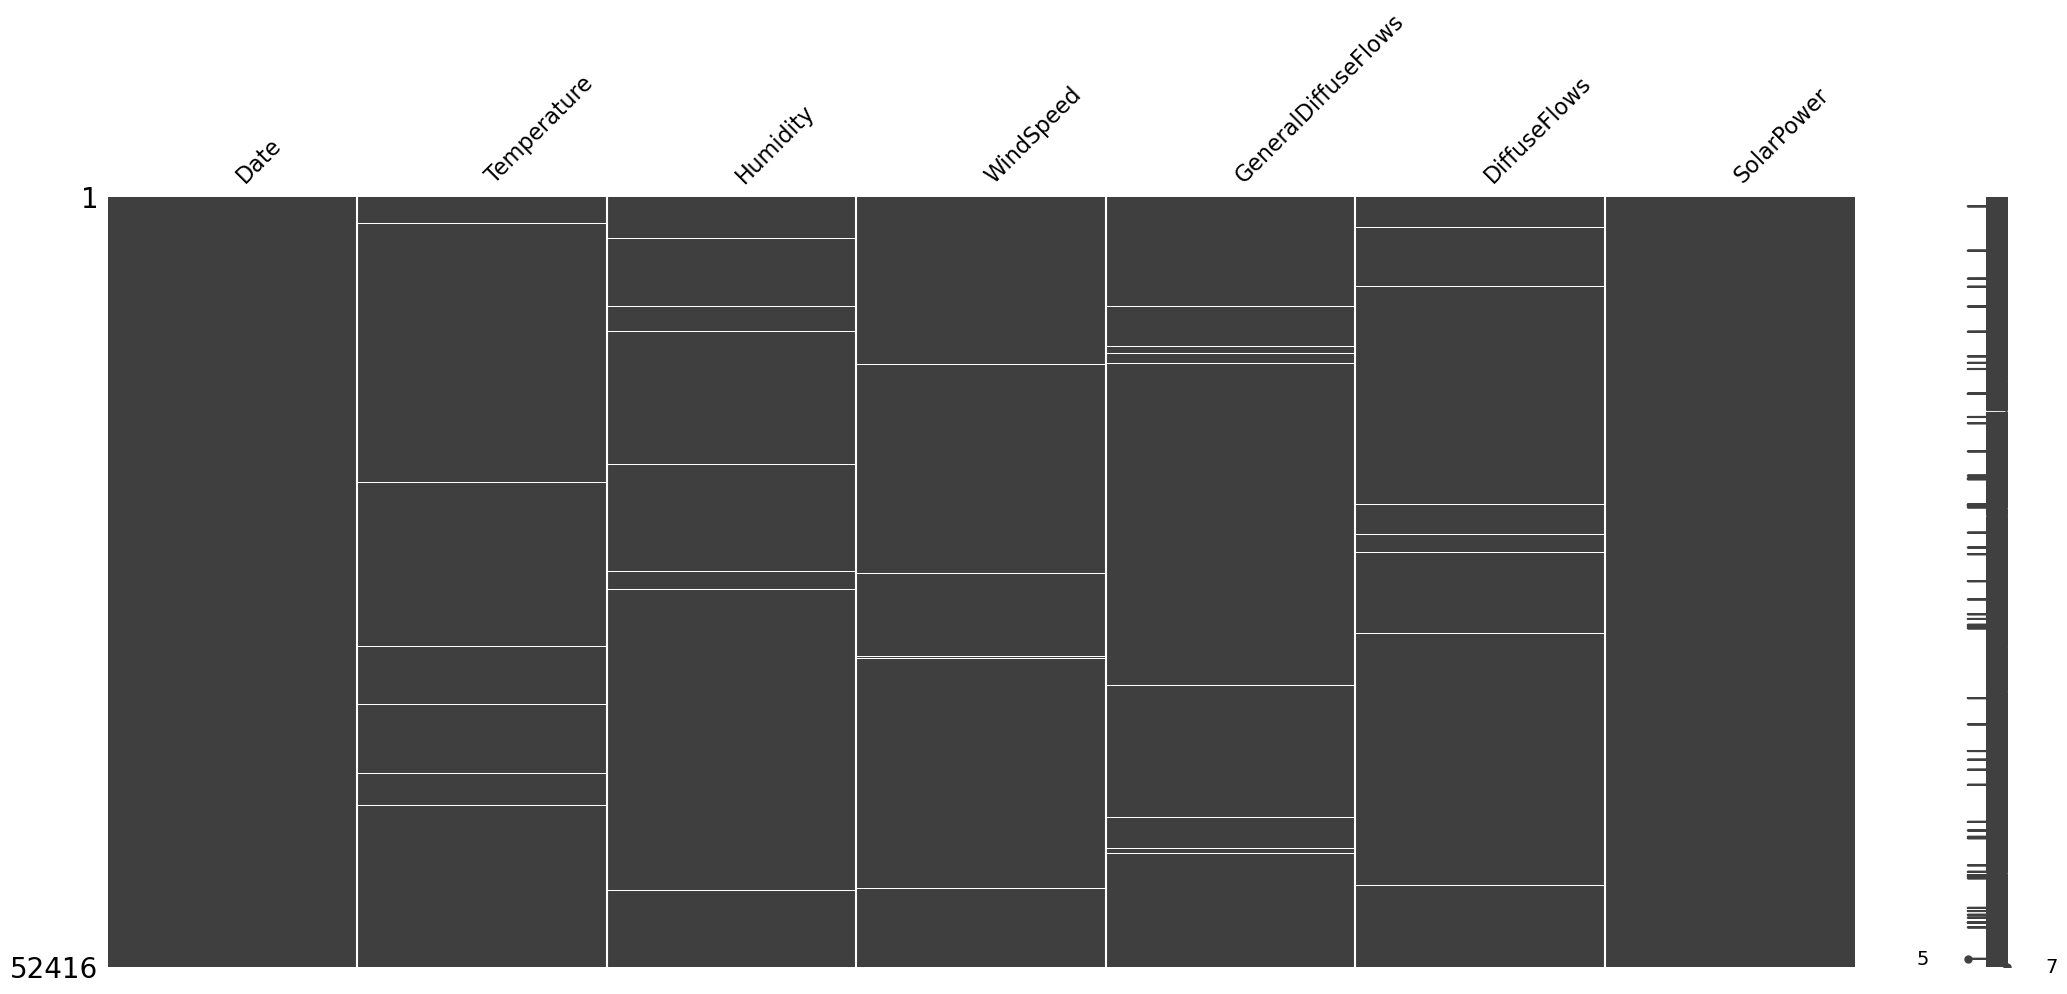

In [329]:
msno.matrix(copy_df)

<Axes: >

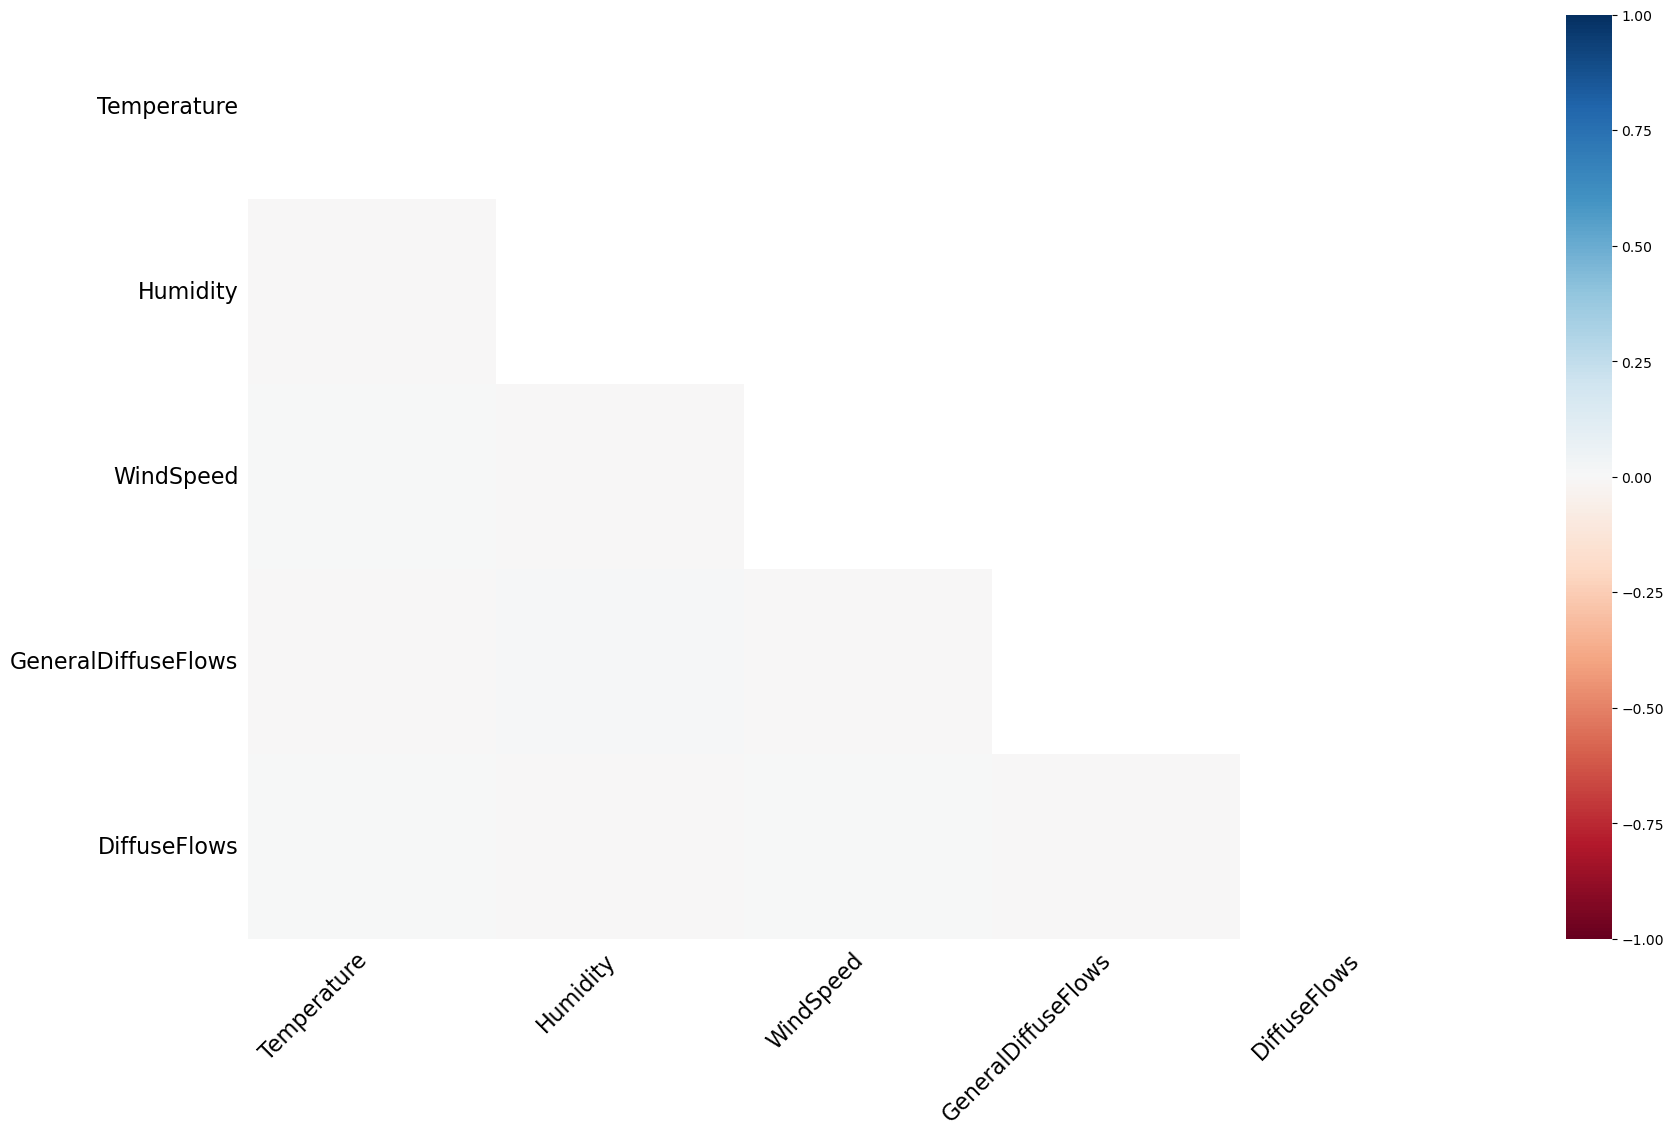

In [331]:
msno.heatmap(copy_df)

In [335]:
imputer = SimpleImputer(strategy='mean')
copy_df[['Temperature','WindSpeed']] = imputer.fit_transform(copy_df[['Temperature','WindSpeed']])
columns = ['Humidity', 'GeneralDiffuseFlows', 'DiffuseFlows']
imputer2 = SimpleImputer(strategy = 'median')
copy_df[columns] = imputer2.fit_transform(copy_df[columns])
copy_df.isnull().sum()


Date                   0
Temperature            0
Humidity               0
WindSpeed              0
GeneralDiffuseFlows    0
DiffuseFlows           0
SolarPower             0
dtype: int64

<Axes: >

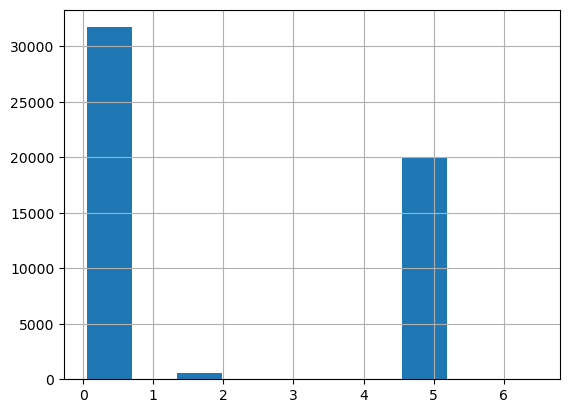

In [337]:
copy_df['WindSpeed'].hist()

## Group the datasets into time intervals of 2 hours

In [340]:
copy_df['Date'] = pd.to_datetime(copy_df['Date'])
copy_df.set_index('Date', inplace=True)
df_resampled = copy_df.resample('2h').mean()
df_resampled

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower
Date,,,,,,
2017-01-01 00:00:00,6.952890,75.630833,0.081917,0.060167,0.105667,26927.594937
2017-01-01 02:00:00,5.029333,78.008333,0.082583,0.061417,0.135083,21447.088607
2017-01-01 04:00:00,4.919667,74.641667,0.081667,0.061917,0.120833,20641.518987
2017-01-01 06:00:00,4.512750,74.575000,0.082417,0.063583,0.122500,20094.683545
2017-01-01 08:00:00,4.632167,73.791667,0.082417,79.281917,15.761833,21255.189872
...,...,...,...,...,...,...
2017-12-30 14:00:00,14.513333,42.018333,0.077667,409.650000,42.163333,29293.789606
2017-12-30 16:00:00,14.015000,45.455833,0.077500,153.905000,152.368333,31262.864386
2017-12-30 18:00:00,10.112500,61.041667,0.075583,1.618917,1.676750,37721.673005


## Create lags

In [365]:
for lag in range(1, 5):
    df_resampled.loc[:, f'SolarPower_lag_{lag}'] = df_resampled['SolarPower'].shift(lag)
df_resampled = df_resampled.dropna()
df_resampled

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower,SolarPower_lag_1,SolarPower_lag_2,SolarPower_lag_3,SolarPower_lag_4
Date,,,,,,,,,,
2017-01-02 16:00:00,15.102500,61.202500,0.076667,156.050000,166.453333,33509.873419,28791.392405,29533.670886,27304.810127,24436.962025
2017-01-02 18:00:00,13.865000,67.693333,0.075750,1.839333,1.889333,41623.291139,33509.873419,28791.392405,29533.670886,27304.810127
2017-01-02 20:00:00,13.268333,67.803333,0.075250,0.058083,0.094917,40278.987343,41623.291139,33509.873419,28791.392405,29533.670886
2017-01-02 22:00:00,12.675000,70.195833,0.074750,0.067750,0.118917,32971.645569,40278.987343,41623.291139,33509.873419,28791.392405
2017-01-03 00:00:00,11.985833,74.050000,0.075667,0.067667,0.145917,23953.417721,32971.645569,40278.987343,41623.291139,33509.873419
...,...,...,...,...,...,...,...,...,...,...
2017-12-30 14:00:00,14.513333,42.018333,0.077667,409.650000,42.163333,29293.789606,30490.240812,29649.683142,23720.152091,21307.984791
2017-12-30 16:00:00,14.015000,45.455833,0.077500,153.905000,152.368333,31262.864386,29293.789606,30490.240812,29649.683142,23720.152091
2017-12-30 18:00:00,10.112500,61.041667,0.075583,1.618917,1.676750,37721.673005,31262.864386,29293.789606,30490.240812,29649.683142


In [367]:
corr_matrix = df_resampled.corr()
print(corr_matrix['SolarPower']) 

Temperature            0.447324
Humidity              -0.295592
WindSpeed              0.171393
GeneralDiffuseFlows    0.197256
DiffuseFlows           0.102838
SolarPower             1.000000
SolarPower_lag_1       0.768416
SolarPower_lag_2       0.345101
SolarPower_lag_3       0.010770
SolarPower_lag_4      -0.198387
Name: SolarPower, dtype: float64


# Split the dataset into 80% training and 20% testing datasets

In [395]:
X = df_resampled[['SolarPower_lag_1','SolarPower_lag_2','Temperature','Humidity']]
Y = df_resampled['SolarPower']
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Create the model, pre-process the data and make it suitable for training

In [398]:
model = XGBRegressor()
model.fit(X_train,Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [413]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
y_pred = model.predict(X_test)
mae = mean_absolute_error(Y_test, y_pred)
r2_score(Y_test,y_pred)

0.8312266722121242

## Perofrm hyper-parameter optimization with a 5-fold cross validation.

Important: Do not use many values for the hyper-parameters due to time constraints.

KEEP IN MIND THE DATASET IS TIME-SERIES.

In [470]:
from sklearn.model_selection import KFold, RepeatedKFold
rkf = RepeatedKFold(n_splits=5)
rkf.get_n_splits(X, Y)

50

In [472]:
param_grid={
    'n_estimators':[50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2]
}

In [474]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=rkf,scoring='r2')
grid.fit(X,Y)

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 5],
                         'n_estimators': [50, 100]},
             scoring='r2')

In [476]:
grid.best_score_

0.8439799835848385

In [478]:
model.get_xgb_params

<bound method XGBModel.get_xgb_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)>

## Fit the model with the best parameters on the training dataset

In [481]:
model.fit(X_train,Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Calculate the adequate metrics on the testing dataset

In [484]:
y_pred = model.predict(X_test)

In [486]:
r2_score(Y_test,y_pred)

0.8312266722121242

## Visualize the targets against the predictions

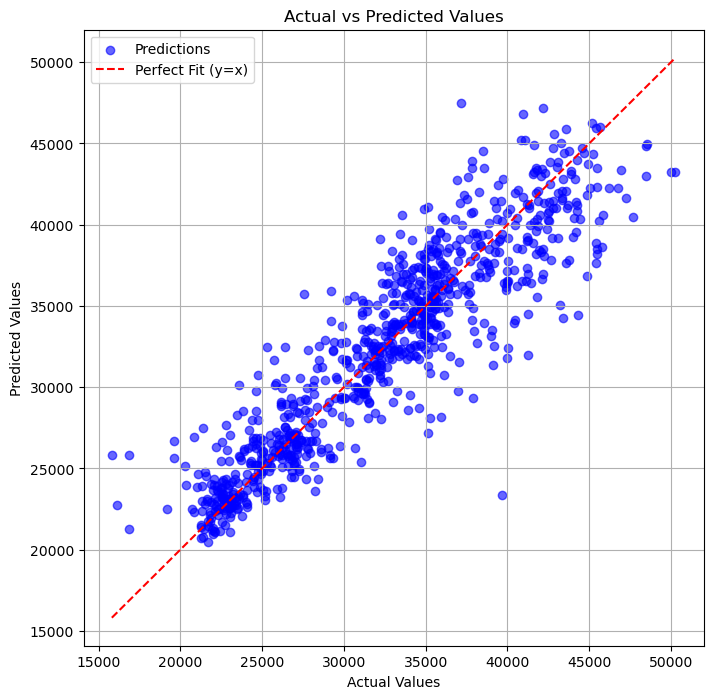

In [520]:
import matplotlib.pyplot as plt

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(Y_test, y_pred, alpha=0.6, color='blue', label='Predictions')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--', label='Perfect Fit (y=x)')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

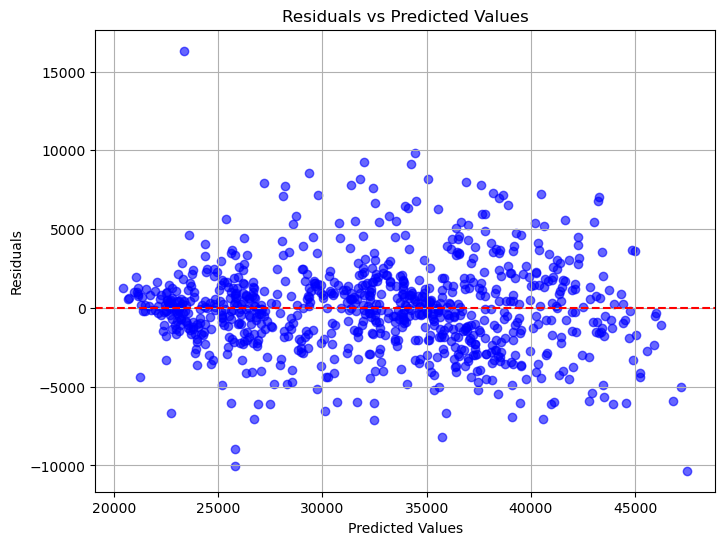

In [516]:
residuals = Y_test - y_pred

# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

C:\Users\Gjurgjica Mladenova\AppData\Local\Temp\ipykernel_22180\1638704765.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(Y_test, label='Actual Values', shade=True, color='blue')
C:\Users\Gjurgjica Mladenova\AppData\Local\Temp\ipykernel_22180\1638704765.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred, label='Predicted Values', shade=True, color='green')


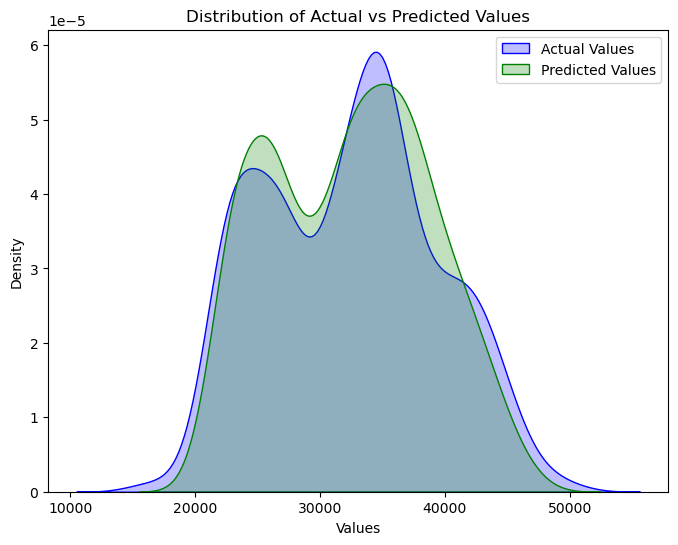

In [518]:
import seaborn as sns

# KDE plot for actual vs predicted
plt.figure(figsize=(8, 6))
sns.kdeplot(Y_test, label='Actual Values', shade=True, color='blue')
sns.kdeplot(y_pred, label='Predicted Values', shade=True, color='green')
plt.title("Distribution of Actual vs Predicted Values")
plt.xlabel("Values")
plt.ylabel("Density")
plt.legend()
plt.show()